# Analyzing business potential of areas in Pune, India

### Table of contents

[1. Deciding initial search locations and getting their coordinates](#one)

[2. Searching for venues around areas with prospects (using Foursquare API)](#two)

[3. Visualizing all venues on map](#three)

[4. Clustering the venues](#four)

[5. Visualizing the clusters on map](#five)

[6. Analyzing the clusters](#six)

[7. Analyzing connectivity by road to business areas](#seven)

[8. Locating the banks and ATM's near business areas](#eight)

[9. Conclusion](#nine)

### Deciding initial search locations and getting their coordinates <a name="one"></a>

#### Importing required libraries

In [1]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim      # geolocation library
import requests                          # to handle requests to urls

#### Function to get coordinates from list of address

Using Nominatim() for geolocation from geopy library to get the value of latitude and longitude from address

In [2]:
def get_coordinates(address_list):
    geolocator = Nominatim(user_agent="wain")
    locations = pd.DataFrame(columns=['Area name', 'latitude', 'longitude'])
    for address in address_list:
        try:
            location = geolocator.geocode(address)
            latitude = location.latitude
            longitude = location.longitude
        except:                                  # incase the address entered is not found, an exception will be thrown.
            latitude = 'Address not found'
            longitude = 'Address not found'
        locations = locations.append(
            {
                'Area name': address,
                'latitude': latitude,
                'longitude': longitude
            },
            ignore_index=True)
    return locations

#### Making a dataframe of locations around which to search for venues using Foursquare API

The areas I selected are surrounded by the most bustling business locations. I selected the first five locations in the list below initially, but not whole city of Pune was covered. So later I added 6th location.

In [44]:
# list of areas that I decided upon, venues around these locations will be used
address = ['Shankar Kalat nagar','Pimpri-Chinchwad','Aundh,Pune','Kothrud','Koregaon Park','Hadapsar']
locations = get_coordinates(address)
locations

Area name   latitude  longitude
0  Shankar Kalat nagar  18.604093  73.754065
1     Pimpri-Chinchwad  18.627929  73.800983
2           Aundh,Pune  18.561883  73.810196
3              Kothrud  18.503889  73.807673
4        Koregaon Park  18.537553  73.893925
5             Hadapsar  18.519805  73.934446

### Searching for venues around areas with prospects (using Foursquare API)<a name="two"></a>

#### Defining Foursquare credentials

In [45]:
# hide this cell
# credential foursquare API
CLIENT_ID = 'DMMNDCKP4HCEBKNG0OZUKP4HQ4G2ARKETXFJLZOI1DY001IT' # your Foursquare ID
CLIENT_SECRET = 'BNOTBJCDHCHRJ3Z1EAMLB0TXSCA4RUH1HSABRTIV33ERSMAM' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

#### A function to get list of venues around a coordinate

In [46]:
import json
from pandas.io.json import json_normalize

Using the Foursquare API to get list of venues around the coordinates passed

In [47]:
def get_venues(lat, lon):
    LIMIT = 100
    radius = 5000
    try:
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lon, radius, LIMIT)
        results = requests.get(url).json()
        venues = results['response']['groups'][0]['items']
        nearby_venues = json_normalize(venues)  # flatten JSON
        filtered_columns = [
            'venue.name', 'venue.categories', 'venue.location.lat',
            'venue.location.lng'
        ]
        nearby_venues = nearby_venues.loc[:, filtered_columns]
        nearby_venues['venue.categories'] = nearby_venues.apply(
            get_category_type, axis=1)
        nearby_venues.columns = [
            col.split(".")[-1] for col in nearby_venues.columns
        ]

    except:
        return None

    return nearby_venues

####  Function that extracts the category of the venue-->   Function obtained from Foursquare lab.

In [48]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### Making a dataframe containing the venues and their coordinates.

In [49]:
df_venues = pd.DataFrame(columns=['name','categories','lat','lng'])
for i in range (0,len(locations.index)):
    df_venues = df_venues.append(get_venues(locations.latitude[i],locations.longitude[i]))
    
df_venues.shape

(594, 4)

The index in dataframe will repeat starting from 0 for each of the six locations in the above loop. Hence there is a need to set the index in order

In [50]:
df_venues.reset_index(drop=True, inplace=True)
df_venues.head()

name          categories        lat        lng
0                 Sayaji               Hotel  18.599535  73.754995
1      Natural Ice Cream      Ice Cream Shop  18.591192  73.752440
2        Barbeque Nation           BBQ Joint  18.599390  73.755090
3  Courtyard by Marriott               Hotel  18.591527  73.746831
4           Little Italy  Italian Restaurant  18.591513  73.743668

The radius for search around the initial locations was km. There was probability of same venues existing in the range of search radius from two areas. Therefore removing duplicate venue rows.

In [51]:
df_venues = df_venues.drop_duplicates()

It can be seen from the shape of the df_venues dataframe that there were some duplicate venues present. The initial number of rows where 594 and 488 rows after removing duplicates.

In [52]:
df_venues.shape

(488, 4)

### Visualizing all venues on map<a name="three"></a>

Using Folium library for plotting the venues

In [53]:
import folium

In [54]:
map_ = folium.Map(location=[locations.latitude[2], locations.longitude[2]], zoom_start=12)

# add markers to map
for lat, lng, Categories, name in zip(df_venues['lat'], df_venues['lng'], df_venues['categories'], df_venues['name']):
    label = '{}, {}'.format(name, Categories)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_)  
    
map_

In [55]:
df_venues.to_csv('venues_all.csv',index=False)   # exporting csv for tests

### Clustering the venues<a name="four"></a>

#### Preparing the dataset for clustering algorithm

In [57]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from folium import plugins
import matplotlib.pyplot as plt

Getting only the coordinates of the venues. Other columns like categories and name will only make it difficult to classify the data into clusters. I wanted the clusters to formed based on the locations only. This way it will be easy to identify the areas with good business prospects.

In [56]:
Clus_dataSet = df_venues[['lat','lng']] 
Clus_dataSet.head()

lat        lng
0  18.599535  73.754995
1  18.591192  73.752440
2  18.599390  73.755090
3  18.591527  73.746831
4  18.591513  73.743668

Scaling the value of coordinates so that the algorithm clusters more accurately. If data is not scaled, the number of clusters is very low or only 1 cluster in some cases.

In [58]:
scaler = StandardScaler()
Clus_dataSet_scale = scaler.fit_transform(Clus_dataSet)
Clus_dataSet_scale[0:5]

array([[ 0.99263968, -1.30722634],
       [ 0.79399218, -1.35081551],
       [ 0.98916813, -1.30560295],
       [ 0.80197589, -1.44647548],
       [ 0.80163575, -1.50042664]])

#### Using K-means to cluster venues

I also tested the clusters using DBSCAN, the resulting clusters were good. There were 7 clusters but with some outliers. I would have had to process these outliers seperately or add them to the nearest clusters. The k-means also clustered them into 5 clusters with good distribution according to area. Though not as detailed as DBSCAN but I still decided to use K-means.

#### Finding the best K

In [59]:
dist = []
list_k = list(range(1, 12))      # list of values of k to test for

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(Clus_dataSet_scale)
    dist.append(km.inertia_)   

Using elbow method for finding best k

Text(0, 0.5, 'Sum of squared distance')

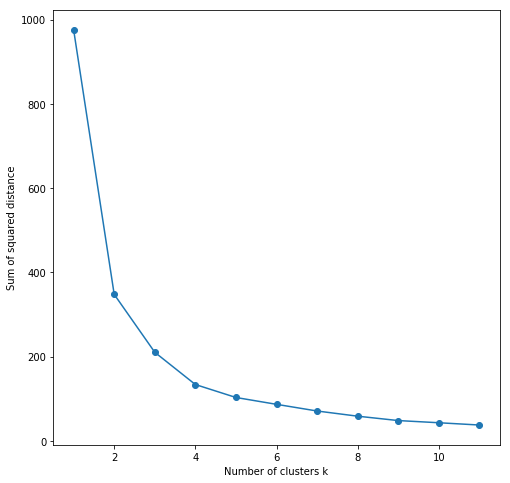

In [60]:
# Plot dist against k
plt.figure(figsize=(8, 8))
plt.plot(list_k, dist, '-o')
plt.xlabel('Number of clusters k')
plt.ylabel('Sum of squared distance')

There is no proper elbow seen in the graph. So I decided to use k=5. The graph starts to straighten out after this point with almost no change in slope.

#### Fitting the data on K-means algorithm

In [92]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Clus_dataSet_scale)

# check cluster labels generated for each row in the dataframe
labels = kmeans.labels_
labels[:50]

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 0, 3, 0, 3, 0, 2, 3, 0, 0, 3,
       0, 0, 2, 2, 3, 3, 2, 3, 3, 0, 0, 3, 0, 3, 0, 0, 3, 0, 0, 3, 3, 3,
       3, 3, 2, 0, 3, 0])

### Visualizing the clusters on map<a name="five"></a>

In [62]:
color_options = [
    'black', 'blue', 'red', 'purple', 'darkgreen', 'darkpurple',
    'darkred', 'gray', 'green', 'lightblue', 'lightgreen', 'lightred',
    'orange', 'pink'
]
map_clus = folium.Map(location=[locations.latitude[2], locations.longitude[2]],
                      zoom_start=11)
# add markers to map
for lat, lng, Categories, name, lab in zip(df_venues['lat'], df_venues['lng'],
                                           df_venues['categories'],
                                           df_venues['name'], labels):
    label = '{}, {}'.format(name, Categories, lab)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng],
                        radius=1,
                        popup=label,
                        color=color_options[lab],
                        fill=True,
                        fill_opacity=1,
                        parse_html=False).add_to(map_clus)

map_clus

### Analyzing the clusters<a name="six"></a>

#### Adding Cluster labels column to separate dataframe according to cluster

In [63]:
df_venues.insert(0, 'Cluster Labels', labels)
df_venues.head()

Cluster Labels                   name          categories        lat  \
0               3                 Sayaji               Hotel  18.599535   
1               3      Natural Ice Cream      Ice Cream Shop  18.591192   
2               3        Barbeque Nation           BBQ Joint  18.599390   
3               3  Courtyard by Marriott               Hotel  18.591527   
4               3           Little Italy  Italian Restaurant  18.591513   

         lng  
0  73.754995  
1  73.752440  
2  73.755090  
3  73.746831  
4  73.743668

#### Function for getting address from coordinates

Using Nominatim() from geopy library for reverse geolocation.

In [69]:
def get_address(coordinates_list):
    reverse_geolocator = Nominatim(user_agent="wain")
    area_name = []
    for coord in coordinates_list:
        try:
            address = reverse_geolocator.reverse(coord)
            x = str(address)
            area_name.append(x.split(',')[-6])
        except:
            x = 'Address not found'
            area_name.append(x)        
    return area_name

#### Preparing dataframe for Cluster with label 0

In [112]:
Cluster_0 = df_venues.loc[df_venues['Cluster Labels'] == 0]
Cluster_0.reset_index(drop=True, inplace=True)        # index will be taken from original df, hence need to reset index
Cluster_0.head()

Cluster Labels                          name               categories  \
0               0                 Urban Foundry                   Lounge   
1               0                     Incognito       Italian Restaurant   
2               0                    CopaCabana        Indian Restaurant   
3               0  Shaolin- The Chinese Cuisine       Chinese Restaurant   
4               0                Way Down South  South Indian Restaurant   

         lat        lng  
0  18.569289  73.774725  
1  18.570376  73.774607  
2  18.589074  73.782483  
3  18.588343  73.783514  
4  18.566366  73.770707

Converting to list to get the area name from address

In [113]:
Cluster_0_coord = Cluster_0[['lat','lng']].values.tolist()
Cluster_0_coord[:5]

[[18.569289409666702, 73.7747245463514],
 [18.570376414375, 73.77460705928516],
 [18.589073641597903, 73.78248319675856],
 [18.58834307568542, 73.78351414844718],
 [18.56636563963199, 73.77070666006395]]

Getting a list of area name for each venue using reverse geolocation

In [114]:
area_name = get_address(Cluster_0_coord)
area_name[:5]

[' Mhalunge', ' Mhalunge', ' Balewadi', ' Balewadi', ' Mhalunge']

In [115]:
Cluster_0.insert(0, 'Area_name', area_name)
Cluster_0.head()

Area_name  Cluster Labels                          name  \
0   Mhalunge               0                 Urban Foundry   
1   Mhalunge               0                     Incognito   
2   Balewadi               0                    CopaCabana   
3   Balewadi               0  Shaolin- The Chinese Cuisine   
4   Mhalunge               0                Way Down South   

                categories        lat        lng  
0                   Lounge  18.569289  73.774725  
1       Italian Restaurant  18.570376  73.774607  
2        Indian Restaurant  18.589074  73.782483  
3       Chinese Restaurant  18.588343  73.783514  
4  South Indian Restaurant  18.566366  73.770707

#### Preparing dataframes for clusters with labels 1,2,3 and 4

In [147]:
Cluster_1 = df_venues.loc[df_venues['Cluster Labels'] == 1]
Cluster_1.reset_index(drop=True, inplace=True)
Cluster_1_coord = Cluster_1[['lat','lng']].values.tolist()
area_name = get_address(Cluster_1_coord)
Cluster_1.insert(0, 'Area_name', area_name)
Cluster_1.head()

Area_name  Cluster Labels                          name  \
0      Ghorpuri               1                  Malaka Spice   
1      Ghorpuri               1            Dario's Restaurant   
2      Ghorpuri               1  the French Window Patisserie   
3      Ghorpuri               1                      Squisito   
4   Somwar Peth               1                   Conrad Pune   

           categories        lat        lng  
0    Asian Restaurant  18.537519  73.897719  
1  Italian Restaurant  18.537207  73.888813  
2              Bakery  18.537709  73.897990  
3  Italian Restaurant  18.536395  73.897193  
4               Hotel  18.535020  73.883056

In [144]:
Cluster_2 = df_venues.loc[df_venues['Cluster Labels'] == 2]
Cluster_2.reset_index(drop=True, inplace=True)
Cluster_2_coord = Cluster_2[['lat','lng']].values.tolist()
area_name = get_address(Cluster_2_coord)
Cluster_2.insert(0, 'Area_name', area_name)
Cluster_2.head()

Area_name  Cluster Labels               name            categories  \
0   Chinchwad               2       Nevale Misal  Fast Food Restaurant   
1    Punawale               2         Bakers Hut                Bakery   
2   Chinchwad               2      Hotel Arihant           Snack Place   
3    Punawale               2  Natural Ice Cream        Ice Cream Shop   
4       Ravet               2             D Mart     Convenience Store   

         lat        lng  
0  18.627925  73.780808  
1  18.642342  73.773437  
2  18.626813  73.782451  
3  18.642399  73.773437  
4  18.646531  73.756541

In [145]:
Cluster_3 = df_venues.loc[df_venues['Cluster Labels'] == 3]
Cluster_3.reset_index(drop=True, inplace=True)
Cluster_3_coord = Cluster_3[['lat','lng']].values.tolist()
area_name = get_address(Cluster_3_coord)
Cluster_3.insert(0, 'Area_name', area_name)
Cluster_3.head()

Area_name  Cluster Labels                   name          categories  \
0   Mhalunge               3                 Sayaji               Hotel   
1   Mhalunge               3      Natural Ice Cream      Ice Cream Shop   
2   Mhalunge               3        Barbeque Nation           BBQ Joint   
3   Mhalunge               3  Courtyard by Marriott               Hotel   
4   Mhalunge               3           Little Italy  Italian Restaurant   

         lat        lng  
0  18.599535  73.754995  
1  18.591192  73.752440  
2  18.599390  73.755090  
3  18.591527  73.746831  
4  18.591513  73.743668

In [146]:
Cluster_4 = df_venues.loc[df_venues['Cluster Labels'] == 4]
Cluster_4.reset_index(drop=True, inplace=True)
Cluster_4_coord = Cluster_4[['lat','lng']].values.tolist()
area_name = get_address(Cluster_4_coord)
Cluster_4.insert(0, 'Area_name', area_name)
Cluster_4.head()

Area_name  Cluster Labels                    name        categories  \
0   Model Colony               4  JW Marriott Hotel Pune             Hotel   
1   Model Colony               4           Spice Kitchen  Asian Restaurant   
2   Model Colony               4                  Paasha            Lounge   
3   Model Colony               4     Pune Baking Company            Bakery   
4   Model Colony               4               Crossword         Bookstore   

         lat        lng  
0  18.532412  73.829842  
1  18.531887  73.829571  
2  18.532077  73.829564  
3  18.531972  73.829834  
4  18.534814  73.829770

#### Function to get the top ten venues in each area of a cluster

In [128]:
def get_top_venues(cluster_venues):
    # one hot encoding
    cluster_onehot = pd.get_dummies(cluster_venues[['categories']], prefix="", prefix_sep="")

    # add area name column back to dataframe
    cluster_onehot['Area_name'] = cluster_venues['Area_name'] 

    # move neighborhood column to the first column
    fixed_columns = [cluster_onehot.columns[-1]] + list(cluster_onehot.columns[:-1])
    cluster_onehot = cluster_onehot[fixed_columns]
    cluster_grouped = cluster_onehot.groupby('Area_name').mean().reset_index()
    
    num_top_venues = 10
    indicators = ['st', 'nd', 'rd']

    # create columns according to number of top venues
    columns = ['Area_name']
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    # create a new dataframe
    area_venues_sorted = pd.DataFrame(columns=columns)
    area_venues_sorted['Area_name'] = cluster_grouped['Area_name']

    for ind in np.arange(cluster_grouped.shape[0]):
        area_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cluster_grouped.iloc[ind, :], num_top_venues)

    return area_venues_sorted

Function to sort venues in descending order

In [125]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Preparing a dataframe of cluster center coordinates

In [93]:
cluster_centres = kmeans.cluster_centers_
cluster_centres

array([[ 0.32212752, -0.70016056],
       [-0.54060431,  1.23322698],
       [ 1.92688671, -0.72392735],
       [ 0.86095677, -1.50274035],
       [-0.99516366, -0.05156486]])

To get the coordinates of the cluster centers I thought of two possible ways. One way was to inverse transform the scaled values from the dataset used to train K-means. But then the coordinates wont be any of the locations of the venues. Second way was to get the coordinate of the venue nearest to the cluster centers. KDtree from scipy library can be used to find the point closest to cluster centers.

In [94]:
from scipy import spatial

Getting the row index of the coordinates of the venues closest to cluster centers.

In [95]:
idx = []
for i in range(0,len(cluster_centres)):
    dist,index = spatial.KDTree(Clus_dataSet_scale).query(cluster_centres[i])
    idx.append(index)
idx

[73, 335, 104, 11, 256]

Getting the coordinates of venues from the index

In [96]:
center_coord = Clus_dataSet.iloc[idx][['lat','lng']]
center_coord

lat        lng
73   18.569308  73.781865
403  18.534466  73.899751
105  18.640212  73.791827
11   18.592694  73.742083
306  18.514030  73.828750

#### Analyzing cluster 0

Visualizing Cluster 0 on map

In [124]:
map_0 = folium.Map(location=[locations.latitude[2], locations.longitude[2]], zoom_start=13)

# add markers to map
for lat, lng, Categories, name in zip(Cluster_0['lat'], Cluster_0['lng'], Cluster_0['categories'], Cluster_0['name']):
    label = '{}, {}'.format(name, Categories)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='blue',
        fill=True,
        fill_opacity=1,
        parse_html=False).add_to(map_0)  
    
map_0

It can be seen on the map that areas Pimple saudagar, Pimple nilakh, balewadi, Aundh and Pashan fall under cluster_0.

In [130]:
Cluster_0_top_venues = get_top_venues(Cluster_0)
Cluster_0_top_venues

Area_name 1st Most Common Venue 2nd Most Common Venue  \
0             Aundh                Bakery                   Gym   
1          Balewadi     Indian Restaurant   American Restaurant   
2             Baner     Indian Restaurant                Lounge   
3    Bavdhan Budruk        Ice Cream Shop     Indian Restaurant   
4         Kasarwadi     Indian Restaurant            Restaurant   
5          Mhalunge     Indian Restaurant  Fast Food Restaurant   
6            Pashan  Fast Food Restaurant    Chinese Restaurant   
7     Pimple Nilakh     Recreation Center             Wine Shop   
8   Pimple Saudagar        Sandwich Place        Ice Cream Shop   
9         Kasarwadi  Fast Food Restaurant             Wine Shop   

  3rd Most Common Venue            4th Most Common Venue  \
0        Ice Cream Shop                Indian Restaurant   
1                  Café                      Snack Place   
2      Malay Restaurant  Molecular Gastronomy Restaurant   
3           Beer Garden                        Wine Shop   
4             Wine Shop                             Café   
5                Bistro                  Motorcycle Shop   
6             BBQ Joint                           Bakery   
7                  Café             Fast Food Restaurant   
8           Pizza Place          North Indian Restaurant   
9                  Café               English Restaurant   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0         Grocery Store                  Café                 Diner   
1          Liquor Store    Chinese Restaurant    English Restaurant   
2                  Café        Breakfast Spot           Pizza Place   
3    Chinese Restaurant    English Restaurant            Donut Shop   
4    English Restaurant            Donut Shop                 Diner   
5           Coffee Shop     French Restaurant                  Café   
6           Coffee Shop             Wine Shop    English Restaurant   
7    English Restaurant            Donut Shop                 Diner   
8     Indian Restaurant             Wine Shop                Lounge   
9            Donut Shop                 Diner          Dessert Shop   

  8th Most Common Venue 9th Most Common Venue   10th Most Common Venue  
0          Dessert Shop           Coffee Shop            Jewelry Store  
1            Donut Shop                 Diner             Dessert Shop  
2        Ice Cream Shop           Snack Place  South Indian Restaurant  
3                 Diner          Dessert Shop         Department Store  
4          Dessert Shop      Department Store              Coffee Shop  
5    Italian Restaurant               Brewery           Breakfast Spot  
6            Donut Shop                 Diner             Dessert Shop  
7          Dessert Shop      Department Store              Coffee Shop  
8           Bus Station                  Café       Chinese Restaurant  
9      Department Store           Coffee Shop           Chocolate Shop

It can be seen that there are 10 different areas in CLuster_0. All the most common venues can be seen according to area.

In [135]:
Cluster_0.categories.nunique()

47

In [139]:
Cluster_0.categories.value_counts()

Indian Restaurant                  18
Ice Cream Shop                      7
Fast Food Restaurant                7
Lounge                              5
Café                                5
Chinese Restaurant                  4
Sandwich Place                      4
Pizza Place                         4
Coffee Shop                         3
Shopping Mall                       3
Bakery                              3
North Indian Restaurant             2
American Restaurant                 2
South Indian Restaurant             2
Breakfast Spot                      2
Snack Place                         2
Brewery                             2
Gym                                 2
Dessert Shop                        2
Recreation Center                   1
Molecular Gastronomy Restaurant     1
Beer Garden                         1
Donut Shop                          1
Restaurant                          1
BBQ Joint                           1
Motorcycle Shop                     1
Punjabi Rest

#### Analyzing cluster 1

In [150]:
map_1 = folium.Map(location=[Cluster_1['lat'][0], Cluster_1['lng'][0]], zoom_start=13)

# add markers to map
for lat, lng, Categories, name in zip(Cluster_1['lat'], Cluster_1['lng'], Cluster_1['categories'], Cluster_1['name']):
    label = '{}, {}'.format(name, Categories)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='blue',
        fill=True,
        fill_opacity=1,
        parse_html=False).add_to(map_1)  
    
map_1

###  Analyzing connectivity by road to business areas<a name="seven"></a>

From the data of bus stops and bus routes , it is possible to check public transport connectivity to the potential areas. There were more than 5500 bus stops in and around the city of Pune available in the data. Only those stops which are around the clusters need to be analyzed.

#### Importing stops dataframe and cleaning it

In [103]:
df_stops = pd.read_csv('stops.csv')
df_stops.head()

stop_id stop_code           stop_name  stop_desc  stop_lat  stop_lon  \
0    32769    151131  Forest Office Road        NaN  18.51983  73.63158   
1    32770    152339     Kusalkar Putala        NaN  18.52889  73.82708   
2    32771    154648          Tower Line        NaN  18.67007  73.78613   
3    32772    153069    Nehrunagar Depot        NaN  18.62930  73.81942   
4    32773    151724        Jagtap Chowk        NaN  18.49153  73.90019   

   zone_id  stop_url  location_type  parent_station  stop_timezone  \
0      NaN       NaN            NaN             NaN            NaN   
1      NaN       NaN            NaN             NaN            NaN   
2      NaN       NaN            NaN             NaN            NaN   
3      NaN       NaN            NaN             NaN            NaN   
4      NaN       NaN            NaN             NaN            NaN   

   wheelchair_boarding  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN

Checking whether there are any null values in the needed columns before dropping NaN

In [104]:
df_stops[['stop_lat','stop_lon']].isna().any()

stop_lat    False
stop_lon    False
dtype: bool

In [105]:
df_stops.shape

(5624, 12)

In [106]:
df_stops.dropna(axis=1,inplace=True)
df_stops.drop(columns=['stop_code','stop_id'],inplace=True)
print(df_stops.shape)
df_stops.head()

(5624, 3)


stop_name  stop_lat  stop_lon
0  Forest Office Road  18.51983  73.63158
1     Kusalkar Putala  18.52889  73.82708
2          Tower Line  18.67007  73.78613
3    Nehrunagar Depot  18.62930  73.81942
4        Jagtap Chowk  18.49153  73.90019

#### Removing stops which are not in range of radius of 5km from cluster centers

In [108]:
from geopy import distance    # to calculate distance between two coordinates.

Making a list of cluster centers and bus stop coordinates to calculate distance between stops and centers.

In [109]:
radius = 5
test_point_list = df_stops[['stop_lat','stop_lon']].values.tolist()
test_point_list[:5]

[[18.51983, 73.63158],
 [18.52889, 73.82708000000001],
 [18.670070000000003, 73.78613],
 [18.6293, 73.81942],
 [18.491529999999997, 73.90019000000001]]

In [111]:
center_point_list = center_coord.values.tolist()
center_point_list[:5]

[[18.56930805697316, 73.78186532743666],
 [18.53446645624323, 73.89975061647455],
 [18.64021188847298, 73.79182698615519],
 [18.592693558984053, 73.74208268396602],
 [18.514029983480278, 73.82874953293054]]

Finding coordinates of bus stops inside search radius